it is single current


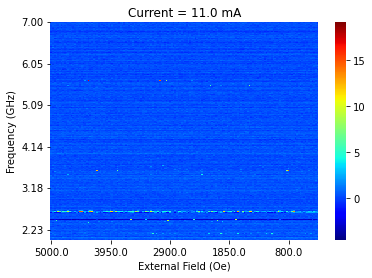

In [10]:
""" Python code to FS PSD of SHNOs for Multi logs including multi Currents and single current  """

# Importing the required libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

# Defining number of "frequencies" which is also number of "rows" in the final matrix
def numbers_of_lines():
    data = open(main_page[log_index + 1],'r')
    line = data.readlines()
    return(len(line)-19)

# removing the hidden files, specifically ".DS_Store" which is usually created by MacOS and add an extra file while reading the folder
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

# Defining if the log contains single or multi currents and return the corresponding value for reading .txt files
def Single_or_multi_Current(lengh):
    if len(lengh) == 1:
        print('it is single current')
        return log_index + len(I_dc) + 1
    else:
        print('it is multi currents')
        return (I_index_num * lengh[1])+log_index


# Giving the path of the desired folder(comprising .txt files of currents)
#path =r"D:\...."  #Windows_Replace your directory
path = "/Users/mona/......."   #MacOs_Replace your directory
main_page1= listdir_nohidden(path)

# Since it is a list,to read it as it is in the folder, we need to sort it
os.chdir(path)
main_page = sorted(main_page1)

#Here it finds the .log files
log_index = 0
log_list = []
for log_file in os.listdir(path):
    if log_file.endswith(".log"):
        log_list.append(log_file)
log_list.sort()
log_len = len(log_list)

# define current
I_dc = []
H_external = []
txt_path = [] #Might be useful later but not now :) so feel free to comment it!

for log_num in range(log_len):  #for several log files
    open_log = open(log_list[log_num],'r') # it reads each log file
    log_index = main_page.index(log_list[log_num])
    input_from_log = open_log.readlines()
    for row_in_log in range(7,len(input_from_log)):
        log_lines = input_from_log[row_in_log]
        splitted_log_lines = str.split(log_lines)
        splitted_log_lines[1] = float(splitted_log_lines[1])*1000
        splitted_log_lines[0] = float(splitted_log_lines[0])
        I_dc.append(splitted_log_lines[1])
        H_external.append(splitted_log_lines[0])
        txt_path.append(splitted_log_lines[2]) #Might be useful later but not now :) so feel free to comment it!

    # Len(I_dc_unique) is the current number
    I_dc_unique = np.unique(I_dc,return_index=True)
    I_dc_unique_index = list(I_dc_unique[1])
    I_dc_unique_values = list(I_dc_unique[0])

    # Len(H_external_Unique) is the field number
    H_external_unique = np.unique(H_external,return_index=True)
    H_external_unique_index = list(H_external_unique[1])
    H_external_unique_index.reverse()
    H_external_unique_values = list(H_external_unique[0])
    H_external_unique_values.reverse()

    # Defining Lists, matrices,....
    frequency = np.zeros(numbers_of_lines())
    matrix_column = 0
    matrix_row = 0
    matrix = (numbers_of_lines(), len(H_external_unique_values))  #number of rows and columns are gotten from number of rows in a file and numbers of unique fields
    PSD_Matrix = np.zeros(matrix)


    # Reading a .txt file and put the embedded rows in a list
    I_start = log_index + 1
    for I_index_num in range(1,len(I_dc_unique_index)+1):
        I_stop = Single_or_multi_Current(I_dc_unique_index)
        for file_number in range(I_start,I_stop):
            data = open(main_page[file_number],'r')
            line = data.readlines()
            # picking freq. and clean spectrum columns for plotting
            for row_in_file in range (18,len(line)-1):     # first 18 lines are not data_ But later we can use them to read resistance
                string = line[row_in_file]
                splitted_string = str.split(string)
                for column_in_file in range(len(splitted_string)):
                    splitted_string[column_in_file] = float(splitted_string[column_in_file])   # type(Splitted_string[i]) is string.So we need to convert it to a number
                frequency[matrix_row] = splitted_string[0]
                PSD_Matrix[matrix_row][matrix_column] = splitted_string[2]
                matrix_row += 1

            if matrix_column < len(H_external_unique_values) :
                matrix_column += 1
                matrix_row = 0
            else:
                matrix_row = 0

        # defining frequency
        frequency = [x/1.e9 for x in frequency]
        for freq in range(0,len(frequency)):
            frequency[freq] = "{:.2f}".format(frequency[freq])



        # defining DataFrame to be able to have our own ticks and axis values
        PSD_array_indexed =pd.DataFrame(PSD_Matrix, index=frequency, columns=H_external_unique_values)
        plt.title(f'Current = {float(I_dc_unique_values[I_index_num-1])} mA')
        heatmap =sns.heatmap(PSD_array_indexed.iloc[::-1],cmap='jet')
        heatmap.set_xlabel('External Field (Oe)')
        heatmap.set_ylabel('Frequency (GHz)')
        plt.locator_params(axis='y', nbins=6)
        plt.locator_params(axis='x', nbins=5)
        plt.xticks(rotation = 0)
        plt.show()
        matrix_column = 0
        I_start = I_stop
        #heatmap.figure.savefig(r'D:\.....\H_ext = '+str(float(I_dc_unique_values[I_index_num-1]))+' mA.png')  #Win :save your plot in the desired directory
        heatmap.figure.savefig('/Users/..../H_ext = '+str(float(I_dc_unique_values[I_index_num-1]))+' mA.png')    #MacOs :save your plot in the desired directory

    I_dc = []
    H_external = []

